In [128]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import logging
import warnings
import random
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import AdamW
import pandas as pd
from icecream import ic

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
# from darts.datasets import AirPassengersDataset, ElectricityDataset, MonthlyMilkDataset
from darts.metrics import mape
from darts.models import (
    BlockRNNModel,
    NBEATSModel,
)
from darts.utils.callbacks import TFMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import seed_everything
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# from torch.optim import AdamW

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
seed_everything(42)


42

#### Many TFM arguments for controlling fitting and instrumentation

In [129]:
# log_dir = r"/workspaces/darts/examples/darts_logs/fit_air/logs"
# sub_dir = "100_32"
# tensorboard_logger = TensorBoardLogger(save_dir=log_dir, name=sub_dir)

# pl_trainer_kwargs = {
#     "accelerator": "cpu",
#     "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
#     "logger": tensorboard_logger,
# }

# # Import AdamW optimizer
# from torch.optim import AdamW

# model_fit_air = NBEATSModel(
#     input_chunk_length=24,
#     output_chunk_length=12,
#     n_epochs=50,
#     batch_size=32,
#     optimizer_cls=AdamW,  # Specify AdamW optimizer
#     optimizer_kwargs={"lr": 1e-3, "weight_decay": 1e-1},
#     random_state=0,
#     log_tensorboard=True,
#     model_name="fit_air",    
#     pl_trainer_kwargs=pl_trainer_kwargs,
# )

# model_fit_air.fit(air_train, val_series=air_val, verbose=True)


The idea is to simulate an environment where only one series can be held in memory at a time.

Functions to save and load files:
1. Raw data
2. Scalars used to fit
3. Series

In [130]:
raw_data_path = Path("../datasets")
scaler_path = Path("../datasets/scalers")
scaled_data_path = Path("../datasets/scaled")
train_data_path = Path("../datasets/train")
val_data_path = Path("../datasets/val")

def load_data_file(filename, relative_path):
    file_path = relative_path / filename
    df = pd.read_csv(file_path, header=0, index_col="Month", parse_dates=True, dtype=np.float32)
    df = df.asfreq('MS')
    series = TimeSeries.from_dataframe(df)    
    return series

def save_series_to_csv(series, filename, relative_path):
    file_path = relative_path / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)    
    series.to_csv(file_path)

def create_scaler(scaler, name):
    if scaler == "MinMaxScaler":
        return Scaler(scaler=MinMaxScaler(feature_range=(0, 1)), name=name)
    elif scaler == "StandardScaler":
        return Scaler(scaler=StandardScaler(), name=name)
    
def save_scaler(scaler, filename, relative_path):
    file_path = relative_path / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)    
    with open(file_path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(filename, relative_path):
    file_path = relative_path / filename
    with open(file_path, 'rb') as f:
        scaler = pickle.load(f)
    return scaler    


1. Load raw data files
2. Create scalars and series
3. Save scalars and series to files
4. Delete large memory objects, as we are simulating having to read from files when multiple series are too big for memory

In [131]:
air_series_raw = load_data_file("AirPassengers.csv", raw_data_path)
air_scaler = create_scaler("MinMaxScaler", "air")
air_scaler = air_scaler.fit(air_series_raw)
air_series_scaled = air_scaler.transform(air_series_raw)
save_scaler(air_scaler, "air.pkl", scaler_path)
save_series_to_csv(air_series_scaled, "AirPassengers.csv", scaled_data_path)
air_train, air_val = air_series_scaled[:-36], air_series_scaled[-36:]
save_series_to_csv(air_train, "air_train.csv", train_data_path)
save_series_to_csv(air_val, "air_val.csv", val_data_path)

milk_series_raw = load_data_file("monthly-milk.csv", raw_data_path)
milk_scaler = create_scaler("MinMaxScaler", "milk")
milk_scaler = milk_scaler.fit(milk_series_raw)
milk_series_scaled = milk_scaler.transform(milk_series_raw)
save_scaler(milk_scaler, "milk.pkl", scaler_path)
save_series_to_csv(milk_series_scaled, "monthly-milk.csv", scaled_data_path)
milk_train, milk_val = milk_series_scaled[:-36], milk_series_scaled[-36:]                
save_series_to_csv(milk_train, "milk_train.csv", train_data_path)
save_series_to_csv(milk_val, "milk_val.csv", val_data_path)

del air_scaler
del air_series_scaled
del air_train
del air_val

del milk_scaler
del milk_series_scaled
del milk_train
del milk_val

Verify scalars and scaled series from files

ic| air_scaler: air
ic| milk_scaler: milk


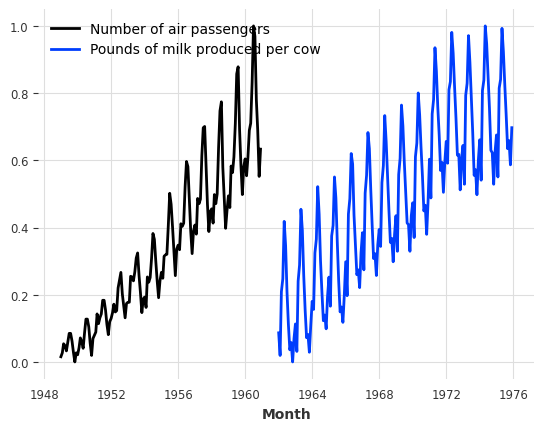

In [132]:
air_scaler = load_scaler("air.pkl", scaler_path)
ic(air_scaler)
air_series_scaled = load_data_file("AirPassengers.csv", scaled_data_path)

milk_scaler = load_scaler("milk.pkl", scaler_path)
ic(milk_scaler)
milk_series_scaled = load_data_file("monthly-milk.csv", scaled_data_path)

air_series_scaled.plot(label="Number of air passengers")
milk_series_scaled.plot(label="Pounds of milk produced per cow")
plt.legend()
plt.show()

del air_scaler
del air_series_scaled
del milk_scaler
del milk_series_scaled  

Verify train and val from files

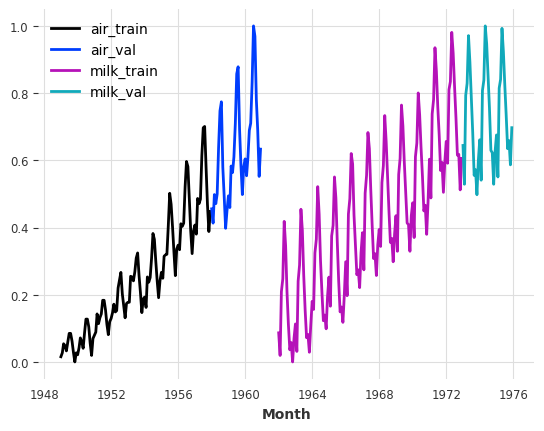

In [133]:
air_train = load_data_file("air_train.csv", train_data_path)
air_val = load_data_file("air_val.csv", val_data_path)

milk_train = load_data_file("milk_train.csv", train_data_path)
milk_val = load_data_file("milk_val.csv", val_data_path)

air_train.plot(label="air_train")
air_val.plot(label="air_val")
milk_train.plot(label="milk_train")
milk_val.plot(label="milk_val")
plt.legend();
plt.show()

del air_train
del air_val

del milk_train
del milk_val

1. Create the smallest history series for prediction
2. Load a validation series

In [134]:
air_train = load_data_file("air_train.csv", train_data_path)
air_hist = air_train[-24:]
del air_train

air_val = load_data_file("air_val.csv", val_data_path)

Emulate the DataLoader/Dataset concept as "file" DataLoader and "file" Dataset with loops over the file dataloader (outer epochs)

In [135]:
class FileDataset():
    def __init__(self, filenames, relative_path):
        self._filenames = filenames
        self._relative_path = relative_path
        self._load_counter = 0

    def __len__(self):
        return len(self._filenames)

    def __getitem__(self, idx):
        return self._load_file(self._filenames[idx])
    
    def _load_file(self, filename):
        self._load_counter += 1
        print(f"file read/file: {self._load_counter:02}-{filename}")
        file_path = self._relative_path / filename
        df = pd.read_csv(file_path, header=0, index_col="Month", parse_dates=True, dtype=np.float32)
        df = df.asfreq('MS')
        return TimeSeries.from_dataframe(df)  

    
class FileDataLoader():
    def __init__(self, dataset, shuffle=False):
        self._dataset = dataset
        self.shuffle = shuffle
        self.n_files = len(self._dataset)

    def __iter__(self):
        self._dataset_indices = list(range(self.n_files))
        if self.shuffle:
            random.shuffle(self._dataset_indices)
        self._next_idx = 0
        return self
    
    def __next__(self):
        if self._next_idx < len(self._dataset_indices):
            dataset_idx = self._dataset_indices[self._next_idx]
            self._next_idx += 1
            return self._dataset[dataset_idx]
        else:
            raise StopIteration

In [136]:
def plot_mapes(mapes):
    plt.plot(range(1, len(mapes)+1), mapes)
    plt.xticks(range(1, len(mapes) + 1))
    plt.show()
    print(mapes)

In [137]:
def reset_NBEATSModel():
    optimizer_kwargs = {"lr": 1e-4}

    log_dir = r"/workspaces/darts/examples/darts_logs/fit_files/logs"
    sub_dir = "milk_air_xtra_air"
    tensorboard_logger = TensorBoardLogger(save_dir=log_dir, name=sub_dir)

    pl_trainer_kwargs = {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
            "logger": tensorboard_logger,
        }


    return NBEATSModel(
        input_chunk_length=24,
        output_chunk_length=12,
        n_epochs=10,
        batch_size=16,
        optimizer_kwargs=optimizer_kwargs,
        random_state=seed,
        log_tensorboard=False,
        model_name="fit_files",    
        pl_trainer_kwargs = pl_trainer_kwargs,
    )


In [147]:
def reset_BlockRNNModels(n_epochs, sub_dir="default"):
    optimizer_kwargs = {"lr": 1e-4, "weight_decay": 1}

    log_dir = r"/workspaces/darts/examples/darts_logs/fit_files/logs"
    sub_dir = sub_dir
    tensorboard_logger = TensorBoardLogger(save_dir=log_dir, name=sub_dir)

    pl_trainer_kwargs = {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
            "logger": tensorboard_logger,
        }

    return BlockRNNModel(
            model="LSTM",
            input_chunk_length=24,
            output_chunk_length=12,
            n_epochs=n_epochs, #30
            batch_size=16,
            optimizer_cls=AdamW,
            optimizer_kwargs=optimizer_kwargs,
            random_state=seed,
            log_tensorboard=True,
            model_name="fit_files",    
            pl_trainer_kwargs = pl_trainer_kwargs,
        )

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

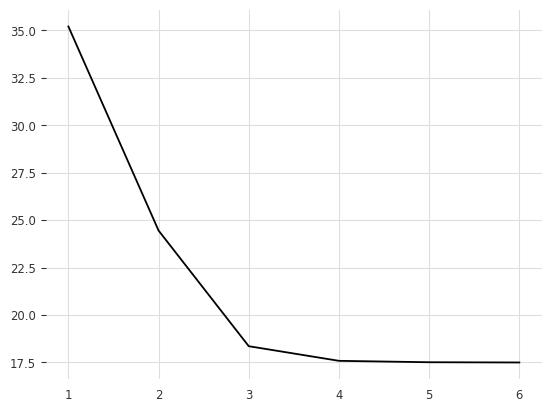

[35.20741, 24.451496, 18.356653, 17.58566, 17.511341, 17.498945]


In [ ]:
mapes = []
for n_epoch in [120, 150, 180, 210, 240, 270]:
    model_fit_files = reset_BlockRNNModels(n_epoch)
    air_train = load_data_file("air_train.csv", train_data_path)
    model_fit_files.fit(series=air_train, val_series=air_val)
    pred = model_fit_files.predict(n=36, series=air_hist)
    mapes.append(mape(air_val, pred))
plot_mapes(mapes)

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

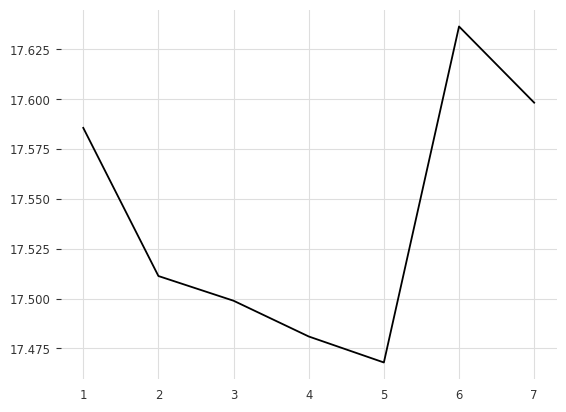

[17.58566, 17.511341, 17.498945, 17.481018, 17.467978, 17.636517, 17.598299]


In [148]:
mapes = []
for n_epoch in [210, 240, 270, 300, 330, 360, 390]:
    model_fit_files = reset_BlockRNNModels(n_epoch, "lstm-epoch_loop-air1")
    air_train = load_data_file("air_train.csv", train_data_path)
    model_fit_files.fit(series=air_train, val_series=air_val)
    pred = model_fit_files.predict(n=36, series=air_hist)
    mapes.append(mape(air_val, pred))
plot_mapes(mapes)

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

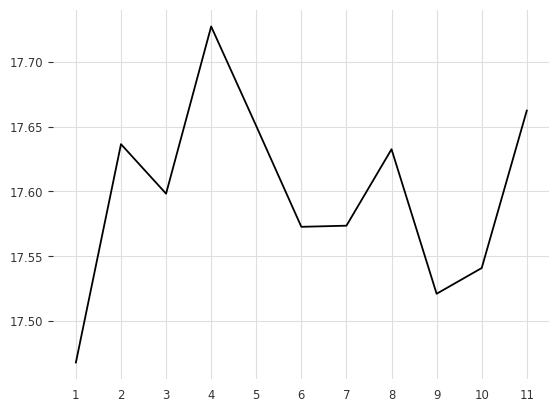

[17.467978, 17.636517, 17.598299, 17.72736, 17.65052, 17.572702, 17.573572, 17.632599, 17.521019, 17.540892, 17.662437]


In [149]:
mapes = []
for n_epoch in [330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630]:
    model_fit_files = reset_BlockRNNModels(n_epoch, "lstm-epoch_loop-air2")
    air_train = load_data_file("air_train.csv", train_data_path)
    model_fit_files.fit(series=air_train, val_series=air_val)
    pred = model_fit_files.predict(n=36, series=air_hist)
    mapes.append(mape(air_val, pred))
plot_mapes(mapes)

In [163]:
# model_fit_files = reset_NBEATSModel()
model_fit_files = reset_BlockRNNModels(1, "epochs_10_66")

mapes = []
milk_air = ["milk_train.csv", "air_train.csv"]
air_milk = ["air_train.csv", "milk_train.csv"]

file_dataset = FileDataset(air_milk, train_data_path)

file_dataloader = FileDataLoader(file_dataset, shuffle=False)
outer_epochs = 660
for outer_epoch in range(outer_epochs):
    print(f"outer_epoch: {outer_epoch+1}")
    for train_series in file_dataloader:
        model_fit_files.fit(series=train_series, val_series=air_val)
        # Potentially delete train_series and call the garbage collector here to free up memory

    pred = model_fit_files.predict(n=36, series=air_hist)
    mapes.append(mape(air_val, pred))

# # fit an extra air
# air_train = load_data_file("air_train.csv", train_data_path)
# model_fit_files.fit(series=air_train, val_series=air_val)
# pred = model_fit_files.predict(n=36, series=air_hist)
# mapes.append(mape(air_val, pred))

# # fit another extra air
# model_fit_files.fit(series=air_train, val_series=air_val)
# pred = model_fit_files.predict(n=36, series=air_hist)
# mapes.append(mape(air_val, pred))


outer_epoch: 1
file read/file: 01-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 02-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 2
file read/file: 03-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 04-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 3
file read/file: 05-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 06-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 4
file read/file: 07-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 08-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 5
file read/file: 09-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 10-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 6
file read/file: 11-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 12-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 7
file read/file: 13-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 14-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 8
file read/file: 15-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 16-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 9
file read/file: 17-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 18-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 10
file read/file: 19-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 20-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 11
file read/file: 21-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 22-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 12
file read/file: 23-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 24-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 13
file read/file: 25-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 26-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 14
file read/file: 27-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 28-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 15
file read/file: 29-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 30-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 16
file read/file: 31-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 32-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 17
file read/file: 33-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 34-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 18
file read/file: 35-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 36-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 19
file read/file: 37-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 38-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 20
file read/file: 39-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 40-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 21
file read/file: 41-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 42-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 22
file read/file: 43-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 44-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 23
file read/file: 45-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 46-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 24
file read/file: 47-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 48-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 25
file read/file: 49-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 50-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 26
file read/file: 51-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 52-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 27
file read/file: 53-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 54-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 28
file read/file: 55-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 56-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 29
file read/file: 57-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 58-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 30
file read/file: 59-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 60-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 31
file read/file: 61-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 62-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 32
file read/file: 63-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 64-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 33
file read/file: 65-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 66-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 34
file read/file: 67-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 68-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 35
file read/file: 69-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 70-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 36
file read/file: 71-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 72-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 37
file read/file: 73-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 74-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 38
file read/file: 75-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 76-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 39
file read/file: 77-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 78-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 40
file read/file: 79-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 80-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 41
file read/file: 81-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 82-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 42
file read/file: 83-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 84-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 43
file read/file: 85-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 86-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 44
file read/file: 87-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 88-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 45
file read/file: 89-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 90-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 46
file read/file: 91-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 92-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 47
file read/file: 93-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 94-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 48
file read/file: 95-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 96-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 49
file read/file: 97-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 98-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 50
file read/file: 99-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 100-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 51
file read/file: 101-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 102-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 52
file read/file: 103-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 104-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 53
file read/file: 105-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 106-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 54
file read/file: 107-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 108-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 55
file read/file: 109-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 110-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 56
file read/file: 111-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 112-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 57
file read/file: 113-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 114-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 58
file read/file: 115-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 116-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 59
file read/file: 117-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 118-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 60
file read/file: 119-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 120-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 61
file read/file: 121-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 122-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 62
file read/file: 123-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 124-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 63
file read/file: 125-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 126-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 64
file read/file: 127-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 128-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 65
file read/file: 129-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 130-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 66
file read/file: 131-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 132-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 67
file read/file: 133-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 134-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 68
file read/file: 135-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 136-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 69
file read/file: 137-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 138-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 70
file read/file: 139-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 140-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 71
file read/file: 141-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 142-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 72
file read/file: 143-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 144-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 73
file read/file: 145-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 146-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 74
file read/file: 147-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 148-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 75
file read/file: 149-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 150-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 76
file read/file: 151-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 152-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 77
file read/file: 153-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 154-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 78
file read/file: 155-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 156-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 79
file read/file: 157-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 158-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 80
file read/file: 159-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 160-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 81
file read/file: 161-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 162-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 82
file read/file: 163-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 164-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 83
file read/file: 165-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 166-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 84
file read/file: 167-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 168-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 85
file read/file: 169-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 170-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 86
file read/file: 171-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 172-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 87
file read/file: 173-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 174-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 88
file read/file: 175-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 176-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 89
file read/file: 177-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 178-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 90
file read/file: 179-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 180-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 91
file read/file: 181-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 182-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 92
file read/file: 183-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 184-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 93
file read/file: 185-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 186-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 94
file read/file: 187-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 188-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 95
file read/file: 189-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 190-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 96
file read/file: 191-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 192-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 97
file read/file: 193-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 194-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 98
file read/file: 195-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 196-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 99
file read/file: 197-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 198-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 100
file read/file: 199-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 200-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 101
file read/file: 201-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 202-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 102
file read/file: 203-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 204-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 103
file read/file: 205-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 206-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 104
file read/file: 207-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 208-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 105
file read/file: 209-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 210-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 106
file read/file: 211-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 212-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 107
file read/file: 213-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 214-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 108
file read/file: 215-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 216-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 109
file read/file: 217-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 218-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 110
file read/file: 219-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 220-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 111
file read/file: 221-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 222-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 112
file read/file: 223-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 224-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 113
file read/file: 225-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 226-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 114
file read/file: 227-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 228-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 115
file read/file: 229-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 230-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 116
file read/file: 231-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 232-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 117
file read/file: 233-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 234-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 118
file read/file: 235-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 236-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 119
file read/file: 237-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 238-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 120
file read/file: 239-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 240-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 121
file read/file: 241-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 242-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 122
file read/file: 243-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 244-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 123
file read/file: 245-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 246-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 124
file read/file: 247-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 248-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 125
file read/file: 249-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 250-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 126
file read/file: 251-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 252-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 127
file read/file: 253-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 254-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 128
file read/file: 255-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 256-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 129
file read/file: 257-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 258-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 130
file read/file: 259-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 260-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 131
file read/file: 261-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 262-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 132
file read/file: 263-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 264-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 133
file read/file: 265-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 266-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 134
file read/file: 267-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 268-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 135
file read/file: 269-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 270-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 136
file read/file: 271-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 272-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 137
file read/file: 273-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 274-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 138
file read/file: 275-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 276-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 139
file read/file: 277-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 278-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 140
file read/file: 279-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 280-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 141
file read/file: 281-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 282-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 142
file read/file: 283-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 284-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 143
file read/file: 285-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 286-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 144
file read/file: 287-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 288-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 145
file read/file: 289-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 290-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 146
file read/file: 291-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 292-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 147
file read/file: 293-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 294-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 148
file read/file: 295-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 296-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 149
file read/file: 297-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 298-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 150
file read/file: 299-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 300-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 151
file read/file: 301-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 302-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 152
file read/file: 303-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 304-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 153
file read/file: 305-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 306-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 154
file read/file: 307-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 308-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 155
file read/file: 309-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 310-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 156
file read/file: 311-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 312-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 157
file read/file: 313-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 314-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 158
file read/file: 315-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 316-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 159
file read/file: 317-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 318-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 160
file read/file: 319-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 320-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 161
file read/file: 321-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 322-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 162
file read/file: 323-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 324-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 163
file read/file: 325-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 326-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 164
file read/file: 327-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 328-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 165
file read/file: 329-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 330-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 166
file read/file: 331-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 332-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 167
file read/file: 333-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 334-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 168
file read/file: 335-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 336-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 169
file read/file: 337-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 338-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 170
file read/file: 339-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 340-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 171
file read/file: 341-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 342-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 172
file read/file: 343-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 344-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 173
file read/file: 345-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 346-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 174
file read/file: 347-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 348-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 175
file read/file: 349-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 350-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 176
file read/file: 351-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 352-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 177
file read/file: 353-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 354-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 178
file read/file: 355-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 356-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 179
file read/file: 357-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 358-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 180
file read/file: 359-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 360-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 181
file read/file: 361-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 362-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 182
file read/file: 363-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 364-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 183
file read/file: 365-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 366-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 184
file read/file: 367-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 368-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 185
file read/file: 369-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 370-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 186
file read/file: 371-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 372-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 187
file read/file: 373-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 374-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 188
file read/file: 375-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 376-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 189
file read/file: 377-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 378-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 190
file read/file: 379-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 380-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 191
file read/file: 381-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 382-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 192
file read/file: 383-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 384-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 193
file read/file: 385-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 386-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 194
file read/file: 387-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 388-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 195
file read/file: 389-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 390-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 196
file read/file: 391-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 392-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 197
file read/file: 393-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 394-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 198
file read/file: 395-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 396-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 199
file read/file: 397-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 398-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 200
file read/file: 399-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 400-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 201
file read/file: 401-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 402-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 202
file read/file: 403-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 404-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 203
file read/file: 405-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 406-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 204
file read/file: 407-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 408-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 205
file read/file: 409-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 410-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 206
file read/file: 411-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 412-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 207
file read/file: 413-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 414-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 208
file read/file: 415-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 416-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 209
file read/file: 417-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 418-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 210
file read/file: 419-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 420-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 211
file read/file: 421-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 422-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 212
file read/file: 423-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 424-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 213
file read/file: 425-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 426-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 214
file read/file: 427-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 428-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 215
file read/file: 429-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 430-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 216
file read/file: 431-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 432-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 217
file read/file: 433-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 434-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 218
file read/file: 435-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 436-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 219
file read/file: 437-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 438-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 220
file read/file: 439-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 440-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 221
file read/file: 441-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 442-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 222
file read/file: 443-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 444-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 223
file read/file: 445-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 446-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 224
file read/file: 447-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 448-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 225
file read/file: 449-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 450-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 226
file read/file: 451-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 452-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 227
file read/file: 453-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 454-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 228
file read/file: 455-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 456-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 229
file read/file: 457-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 458-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 230
file read/file: 459-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 460-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 231
file read/file: 461-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 462-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 232
file read/file: 463-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 464-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 233
file read/file: 465-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 466-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 234
file read/file: 467-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 468-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 235
file read/file: 469-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 470-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 236
file read/file: 471-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 472-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 237
file read/file: 473-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 474-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 238
file read/file: 475-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 476-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 239
file read/file: 477-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 478-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 240
file read/file: 479-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 480-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 241
file read/file: 481-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 482-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 242
file read/file: 483-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 484-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 243
file read/file: 485-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 486-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 244
file read/file: 487-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 488-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 245
file read/file: 489-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 490-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 246
file read/file: 491-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 492-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 247
file read/file: 493-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 494-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 248
file read/file: 495-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 496-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 249
file read/file: 497-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 498-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 250
file read/file: 499-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 500-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 251
file read/file: 501-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 502-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 252
file read/file: 503-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 504-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 253
file read/file: 505-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 506-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 254
file read/file: 507-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 508-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 255
file read/file: 509-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 510-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 256
file read/file: 511-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 512-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 257
file read/file: 513-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 514-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 258
file read/file: 515-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 516-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 259
file read/file: 517-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 518-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 260
file read/file: 519-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 520-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 261
file read/file: 521-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 522-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 262
file read/file: 523-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 524-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 263
file read/file: 525-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 526-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 264
file read/file: 527-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 528-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 265
file read/file: 529-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 530-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 266
file read/file: 531-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 532-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 267
file read/file: 533-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 534-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 268
file read/file: 535-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 536-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 269
file read/file: 537-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 538-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 270
file read/file: 539-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 540-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 271
file read/file: 541-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 542-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 272
file read/file: 543-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 544-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 273
file read/file: 545-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 546-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 274
file read/file: 547-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 548-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 275
file read/file: 549-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 550-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 276
file read/file: 551-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 552-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 277
file read/file: 553-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 554-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 278
file read/file: 555-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 556-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 279
file read/file: 557-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 558-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 280
file read/file: 559-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 560-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 281
file read/file: 561-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 562-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 282
file read/file: 563-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 564-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 283
file read/file: 565-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 566-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 284
file read/file: 567-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 568-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 285
file read/file: 569-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 570-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 286
file read/file: 571-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 572-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 287
file read/file: 573-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 574-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 288
file read/file: 575-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 576-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 289
file read/file: 577-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 578-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 290
file read/file: 579-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 580-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 291
file read/file: 581-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 582-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 292
file read/file: 583-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 584-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 293
file read/file: 585-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 586-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 294
file read/file: 587-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 588-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 295
file read/file: 589-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 590-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 296
file read/file: 591-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 592-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 297
file read/file: 593-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 594-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 298
file read/file: 595-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 596-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 299
file read/file: 597-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 598-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 300
file read/file: 599-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 600-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 301
file read/file: 601-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 602-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 302
file read/file: 603-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 604-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 303
file read/file: 605-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 606-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 304
file read/file: 607-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 608-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 305
file read/file: 609-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 610-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 306
file read/file: 611-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 612-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 307
file read/file: 613-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 614-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 308
file read/file: 615-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 616-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 309
file read/file: 617-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 618-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 310
file read/file: 619-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 620-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 311
file read/file: 621-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 622-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 312
file read/file: 623-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 624-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 313
file read/file: 625-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 626-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 314
file read/file: 627-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 628-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 315
file read/file: 629-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 630-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 316
file read/file: 631-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 632-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 317
file read/file: 633-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 634-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 318
file read/file: 635-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 636-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 319
file read/file: 637-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 638-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 320
file read/file: 639-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 640-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 321
file read/file: 641-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 642-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 322
file read/file: 643-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 644-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 323
file read/file: 645-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 646-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 324
file read/file: 647-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 648-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 325
file read/file: 649-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 650-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 326
file read/file: 651-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 652-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 327
file read/file: 653-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 654-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 328
file read/file: 655-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 656-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 329
file read/file: 657-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 658-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 330
file read/file: 659-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 660-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 331
file read/file: 661-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 662-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 332
file read/file: 663-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 664-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 333
file read/file: 665-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 666-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 334
file read/file: 667-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 668-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 335
file read/file: 669-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 670-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 336
file read/file: 671-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 672-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 337
file read/file: 673-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 674-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 338
file read/file: 675-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 676-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 339
file read/file: 677-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 678-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 340
file read/file: 679-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 680-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 341
file read/file: 681-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 682-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 342
file read/file: 683-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 684-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 343
file read/file: 685-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 686-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 344
file read/file: 687-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 688-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 345
file read/file: 689-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 690-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 346
file read/file: 691-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 692-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 347
file read/file: 693-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 694-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 348
file read/file: 695-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 696-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 349
file read/file: 697-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 698-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 350
file read/file: 699-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 700-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 351
file read/file: 701-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 702-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 352
file read/file: 703-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 704-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 353
file read/file: 705-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 706-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 354
file read/file: 707-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 708-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 355
file read/file: 709-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 710-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 356
file read/file: 711-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 712-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 357
file read/file: 713-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 714-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 358
file read/file: 715-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 716-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 359
file read/file: 717-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 718-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 360
file read/file: 719-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 720-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 361
file read/file: 721-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 722-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 362
file read/file: 723-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 724-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 363
file read/file: 725-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 726-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 364
file read/file: 727-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 728-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 365
file read/file: 729-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 730-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 366
file read/file: 731-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 732-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 367
file read/file: 733-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 734-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 368
file read/file: 735-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 736-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 369
file read/file: 737-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 738-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 370
file read/file: 739-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 740-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 371
file read/file: 741-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 742-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 372
file read/file: 743-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 744-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 373
file read/file: 745-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 746-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 374
file read/file: 747-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 748-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 375
file read/file: 749-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 750-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 376
file read/file: 751-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 752-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 377
file read/file: 753-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 754-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 378
file read/file: 755-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 756-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 379
file read/file: 757-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 758-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 380
file read/file: 759-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 760-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 381
file read/file: 761-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 762-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 382
file read/file: 763-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 764-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 383
file read/file: 765-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 766-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 384
file read/file: 767-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 768-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 385
file read/file: 769-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 770-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 386
file read/file: 771-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 772-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 387
file read/file: 773-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 774-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 388
file read/file: 775-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 776-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 389
file read/file: 777-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 778-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 390
file read/file: 779-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 780-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 391
file read/file: 781-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 782-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 392
file read/file: 783-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 784-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 393
file read/file: 785-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 786-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 394
file read/file: 787-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 788-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 395
file read/file: 789-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 790-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 396
file read/file: 791-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 792-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 397
file read/file: 793-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 794-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 398
file read/file: 795-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 796-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 399
file read/file: 797-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 798-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 400
file read/file: 799-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 800-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 401
file read/file: 801-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 802-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 402
file read/file: 803-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 804-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 403
file read/file: 805-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 806-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 404
file read/file: 807-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 808-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 405
file read/file: 809-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 810-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 406
file read/file: 811-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 812-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 407
file read/file: 813-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 814-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 408
file read/file: 815-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 816-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 409
file read/file: 817-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 818-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 410
file read/file: 819-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 820-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 411
file read/file: 821-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 822-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 412
file read/file: 823-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 824-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 413
file read/file: 825-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 826-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 414
file read/file: 827-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 828-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 415
file read/file: 829-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 830-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 416
file read/file: 831-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 832-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 417
file read/file: 833-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 834-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 418
file read/file: 835-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 836-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 419
file read/file: 837-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 838-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 420
file read/file: 839-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 840-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 421
file read/file: 841-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 842-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 422
file read/file: 843-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 844-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 423
file read/file: 845-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 846-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 424
file read/file: 847-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 848-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 425
file read/file: 849-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 850-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 426
file read/file: 851-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 852-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 427
file read/file: 853-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 854-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 428
file read/file: 855-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 856-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 429
file read/file: 857-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 858-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 430
file read/file: 859-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 860-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 431
file read/file: 861-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 862-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 432
file read/file: 863-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 864-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 433
file read/file: 865-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 866-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 434
file read/file: 867-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 868-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 435
file read/file: 869-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 870-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 436
file read/file: 871-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 872-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 437
file read/file: 873-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 874-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 438
file read/file: 875-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 876-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 439
file read/file: 877-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 878-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 440
file read/file: 879-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 880-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 441
file read/file: 881-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 882-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 442
file read/file: 883-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 884-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 443
file read/file: 885-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 886-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 444
file read/file: 887-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 888-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 445
file read/file: 889-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 890-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 446
file read/file: 891-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 892-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 447
file read/file: 893-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 894-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 448
file read/file: 895-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 896-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 449
file read/file: 897-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 898-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 450
file read/file: 899-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 900-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 451
file read/file: 901-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 902-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 452
file read/file: 903-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 904-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 453
file read/file: 905-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 906-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 454
file read/file: 907-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 908-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 455
file read/file: 909-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 910-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 456
file read/file: 911-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 912-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 457
file read/file: 913-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 914-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 458
file read/file: 915-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 916-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 459
file read/file: 917-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 918-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 460
file read/file: 919-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 920-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 461
file read/file: 921-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 922-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 462
file read/file: 923-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 924-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 463
file read/file: 925-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 926-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 464
file read/file: 927-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 928-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 465
file read/file: 929-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 930-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 466
file read/file: 931-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 932-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 467
file read/file: 933-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 934-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 468
file read/file: 935-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 936-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 469
file read/file: 937-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 938-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 470
file read/file: 939-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 940-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 471
file read/file: 941-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 942-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 472
file read/file: 943-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 944-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 473
file read/file: 945-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 946-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 474
file read/file: 947-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 948-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 475
file read/file: 949-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 950-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 476
file read/file: 951-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 952-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 477
file read/file: 953-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 954-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 478
file read/file: 955-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 956-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 479
file read/file: 957-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 958-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 480
file read/file: 959-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 960-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 481
file read/file: 961-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 962-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 482
file read/file: 963-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 964-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 483
file read/file: 965-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 966-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 484
file read/file: 967-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 968-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 485
file read/file: 969-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 970-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 486
file read/file: 971-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 972-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 487
file read/file: 973-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 974-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 488
file read/file: 975-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 976-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 489
file read/file: 977-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 978-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 490
file read/file: 979-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 980-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 491
file read/file: 981-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 982-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 492
file read/file: 983-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 984-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 493
file read/file: 985-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 986-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 494
file read/file: 987-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 988-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 495
file read/file: 989-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 990-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 496
file read/file: 991-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 992-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 497
file read/file: 993-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 994-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 498
file read/file: 995-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 996-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 499
file read/file: 997-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 998-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 500
file read/file: 999-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1000-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 501
file read/file: 1001-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1002-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 502
file read/file: 1003-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1004-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 503
file read/file: 1005-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1006-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 504
file read/file: 1007-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1008-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 505
file read/file: 1009-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1010-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 506
file read/file: 1011-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1012-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 507
file read/file: 1013-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1014-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 508
file read/file: 1015-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1016-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 509
file read/file: 1017-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1018-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 510
file read/file: 1019-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1020-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 511
file read/file: 1021-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1022-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 512
file read/file: 1023-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1024-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 513
file read/file: 1025-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1026-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 514
file read/file: 1027-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1028-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 515
file read/file: 1029-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1030-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 516
file read/file: 1031-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1032-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 517
file read/file: 1033-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1034-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 518
file read/file: 1035-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1036-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 519
file read/file: 1037-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1038-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 520
file read/file: 1039-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1040-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 521
file read/file: 1041-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1042-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 522
file read/file: 1043-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1044-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 523
file read/file: 1045-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1046-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 524
file read/file: 1047-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1048-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 525
file read/file: 1049-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1050-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 526
file read/file: 1051-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1052-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 527
file read/file: 1053-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1054-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 528
file read/file: 1055-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1056-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 529
file read/file: 1057-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1058-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 530
file read/file: 1059-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1060-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 531
file read/file: 1061-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1062-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 532
file read/file: 1063-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1064-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 533
file read/file: 1065-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1066-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 534
file read/file: 1067-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1068-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 535
file read/file: 1069-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1070-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 536
file read/file: 1071-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1072-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 537
file read/file: 1073-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1074-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 538
file read/file: 1075-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1076-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 539
file read/file: 1077-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1078-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 540
file read/file: 1079-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1080-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 541
file read/file: 1081-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1082-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 542
file read/file: 1083-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1084-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 543
file read/file: 1085-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1086-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 544
file read/file: 1087-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1088-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 545
file read/file: 1089-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1090-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 546
file read/file: 1091-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1092-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 547
file read/file: 1093-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1094-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 548
file read/file: 1095-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1096-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 549
file read/file: 1097-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1098-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 550
file read/file: 1099-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1100-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 551
file read/file: 1101-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1102-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 552
file read/file: 1103-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1104-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 553
file read/file: 1105-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1106-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 554
file read/file: 1107-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1108-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 555
file read/file: 1109-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1110-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 556
file read/file: 1111-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1112-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 557
file read/file: 1113-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1114-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 558
file read/file: 1115-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1116-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 559
file read/file: 1117-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1118-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 560
file read/file: 1119-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1120-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 561
file read/file: 1121-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1122-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 562
file read/file: 1123-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1124-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 563
file read/file: 1125-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1126-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 564
file read/file: 1127-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1128-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 565
file read/file: 1129-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1130-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 566
file read/file: 1131-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1132-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 567
file read/file: 1133-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1134-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 568
file read/file: 1135-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1136-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 569
file read/file: 1137-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1138-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 570
file read/file: 1139-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1140-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 571
file read/file: 1141-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1142-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 572
file read/file: 1143-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1144-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 573
file read/file: 1145-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1146-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 574
file read/file: 1147-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1148-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 575
file read/file: 1149-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1150-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 576
file read/file: 1151-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1152-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 577
file read/file: 1153-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1154-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 578
file read/file: 1155-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1156-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 579
file read/file: 1157-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1158-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 580
file read/file: 1159-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1160-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 581
file read/file: 1161-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1162-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 582
file read/file: 1163-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1164-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 583
file read/file: 1165-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1166-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 584
file read/file: 1167-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1168-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 585
file read/file: 1169-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1170-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 586
file read/file: 1171-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1172-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 587
file read/file: 1173-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1174-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 588
file read/file: 1175-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1176-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 589
file read/file: 1177-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1178-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 590
file read/file: 1179-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1180-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 591
file read/file: 1181-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1182-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 592
file read/file: 1183-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1184-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 593
file read/file: 1185-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1186-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 594
file read/file: 1187-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1188-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 595
file read/file: 1189-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1190-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 596
file read/file: 1191-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1192-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 597
file read/file: 1193-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1194-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 598
file read/file: 1195-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1196-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 599
file read/file: 1197-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1198-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 600
file read/file: 1199-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1200-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 601
file read/file: 1201-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1202-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 602
file read/file: 1203-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1204-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 603
file read/file: 1205-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1206-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 604
file read/file: 1207-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1208-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 605
file read/file: 1209-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1210-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 606
file read/file: 1211-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1212-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 607
file read/file: 1213-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1214-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 608
file read/file: 1215-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1216-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 609
file read/file: 1217-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1218-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 610
file read/file: 1219-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1220-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 611
file read/file: 1221-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1222-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 612
file read/file: 1223-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1224-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 613
file read/file: 1225-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1226-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 614
file read/file: 1227-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1228-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 615
file read/file: 1229-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1230-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 616
file read/file: 1231-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1232-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 617
file read/file: 1233-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1234-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 618
file read/file: 1235-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1236-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 619
file read/file: 1237-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1238-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 620
file read/file: 1239-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1240-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 621
file read/file: 1241-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1242-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 622
file read/file: 1243-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1244-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 623
file read/file: 1245-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1246-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 624
file read/file: 1247-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1248-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 625
file read/file: 1249-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1250-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 626
file read/file: 1251-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1252-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 627
file read/file: 1253-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1254-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 628
file read/file: 1255-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1256-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 629
file read/file: 1257-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1258-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 630
file read/file: 1259-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1260-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 631
file read/file: 1261-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1262-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 632
file read/file: 1263-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1264-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 633
file read/file: 1265-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1266-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 634
file read/file: 1267-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1268-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 635
file read/file: 1269-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1270-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 636
file read/file: 1271-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1272-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 637
file read/file: 1273-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1274-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 638
file read/file: 1275-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1276-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 639
file read/file: 1277-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1278-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 640
file read/file: 1279-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1280-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 641
file read/file: 1281-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1282-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 642
file read/file: 1283-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1284-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 643
file read/file: 1285-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1286-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 644
file read/file: 1287-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1288-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 645
file read/file: 1289-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1290-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 646
file read/file: 1291-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1292-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 647
file read/file: 1293-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1294-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 648
file read/file: 1295-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1296-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 649
file read/file: 1297-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1298-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 650
file read/file: 1299-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1300-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 651
file read/file: 1301-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1302-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 652
file read/file: 1303-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1304-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 653
file read/file: 1305-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1306-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 654
file read/file: 1307-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1308-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 655
file read/file: 1309-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1310-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 656
file read/file: 1311-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1312-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 657
file read/file: 1313-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1314-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 658
file read/file: 1315-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1316-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 659
file read/file: 1317-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1318-milk_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 660
file read/file: 1319-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 1320-milk_train.csv


Training: 0it [00:00, ?it/s]

Why does training with air followed by milk better than milk followed by air?


looking at plots of air and milk, milk has a consistent amplitude throughout the series.  The milk amplitude and frequency are very similar to the end of the air series.  Air on the other hand has an increasing amplitude from beginning to end.  So, the milk series is more consistent with the end of air, thus training with milk is a better fit to the end of air than training with the air series.  Ending the outer epoch on milk moves the network parameters to better fit milk and thus better fit the end of air.


The best MAPE for training just on air is around 17.5, but training on milk only and predicting on air gives a MAPE of 15.96


In the end training with in-memory multi-series is both faster than files and gives a better MAPE, MAPE of approx. 17.12 vs 18.46 (files, milk_air)

#### But, file multi_series does work!

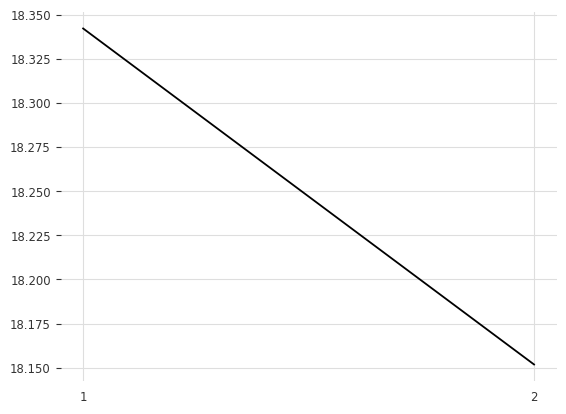

[18.342209, 18.151854]


In [ ]:
plot_mapes(mapes) # milk_air, 2,330

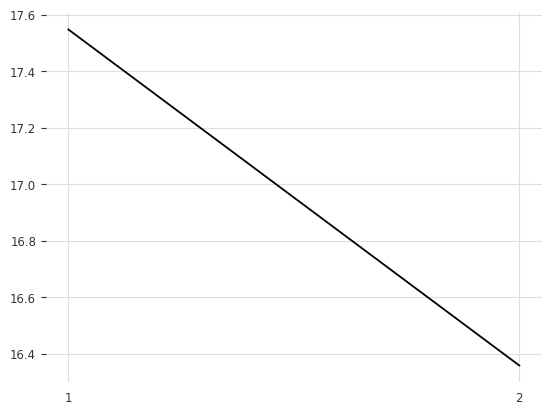

[17.54732, 16.359217]


In [154]:
plot_mapes(mapes) # air_milk, 2,330

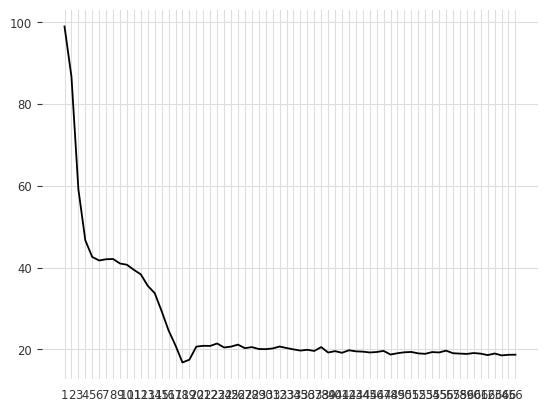

[98.99466, 86.69933, 59.153984, 46.675484, 42.596973, 41.752598, 42.055435, 42.11336, 41.0123, 40.702644, 39.46594, 38.351704, 35.55073, 33.77152, 29.369188, 24.64405, 20.961227, 16.799557, 17.48276, 20.68164, 20.876886, 20.850283, 21.446243, 20.46989, 20.679413, 21.167732, 20.300388, 20.563427, 20.098442, 20.058588, 20.229485, 20.69981, 20.338665, 20.00361, 19.710835, 19.901445, 19.623772, 20.554287, 19.236368, 19.573856, 19.171976, 19.787056, 19.522837, 19.450527, 19.24694, 19.362206, 19.631037, 18.73922, 19.062712, 19.291412, 19.3749, 19.022491, 18.918022, 19.345833, 19.250557, 19.693993, 19.06342, 18.96723, 18.898273, 19.106222, 18.95869, 18.604464, 18.995703, 18.53498, 18.678055, 18.704033]


In [ ]:
plot_mapes(mapes) # milk_air, 66,10

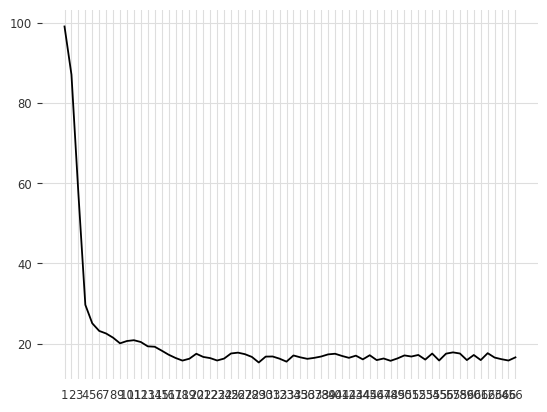

[99.06174, 87.05714, 57.402058, 29.694054, 25.08272, 23.189423, 22.545658, 21.504765, 20.098232, 20.673092, 20.876087, 20.425049, 19.346975, 19.248, 18.282484, 17.271246, 16.452673, 15.79798, 16.262886, 17.499386, 16.706099, 16.413685, 15.818231, 16.292229, 17.568933, 17.77383, 17.396381, 16.717405, 15.323956, 16.789286, 16.817545, 16.271023, 15.531712, 17.072754, 16.603876, 16.231861, 16.476387, 16.811625, 17.343758, 17.499702, 16.952742, 16.482834, 17.024956, 16.10061, 17.12715, 15.916436, 16.317327, 15.7414875, 16.338797, 17.085781, 16.807384, 17.198404, 16.041533, 17.551493, 15.817478, 17.523642, 17.841408, 17.558445, 15.9231615, 17.189066, 15.92477, 17.641125, 16.551004, 16.137165, 15.810852, 16.598148]


In [ ]:
plot_mapes(mapes) # air_milk, 66,10

Just fit on milk and see a great score on air_val

In [159]:
model_fit_files = reset_BlockRNNModels(330, "lstm-330-milk")
milk_train = load_data_file("milk_train.csv", train_data_path)
model_fit_files.fit(series=milk_train, val_series=air_val)
pred = model_fit_files.predict(n=36, series=air_hist)
mape(air_val, pred)

Training: 0it [00:00, ?it/s]

15.959934

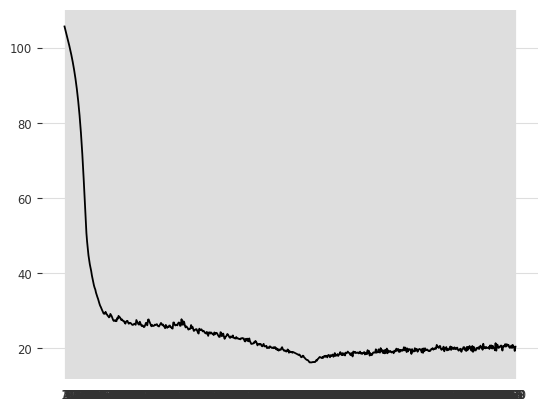

[105.78317, 105.061516, 104.34169, 103.61631, 102.88833, 102.157295, 101.41235, 100.65352, 99.864365, 99.0466, 98.18675, 97.28319, 96.32709, 95.31994, 94.24548, 93.108185, 91.88855, 90.56662, 89.1387, 87.589874, 85.89868, 84.06967, 82.05349, 79.83903, 77.40987, 74.72685, 71.79337, 68.627, 65.1467, 61.485153, 57.764023, 54.0429, 50.72496, 48.439095, 46.543114, 44.803616, 43.48381, 42.37083, 41.45407, 40.584957, 39.426155, 38.542023, 37.655075, 36.770218, 36.143078, 35.65627, 34.837547, 34.230972, 33.690475, 33.1834, 32.527893, 31.930227, 31.38562, 31.031237, 30.555338, 30.146994, 29.766123, 29.313063, 29.18331, 29.315744, 29.72216, 29.145847, 29.074118, 28.69909, 28.554247, 28.240118, 28.415567, 29.165998, 28.87499, 28.541435, 28.086967, 27.559547, 27.299032, 27.365799, 27.535643, 27.240465, 27.251753, 28.066807, 27.895668, 28.649858, 28.267525, 28.268064, 27.908745, 27.535006, 27.707956, 27.439402, 27.229303, 27.233957, 26.797968, 26.574406, 27.093351, 27.287584, 27.310774, 26.842804, 

In [161]:
plot_mapes(mapes) # milk_air, 660,1

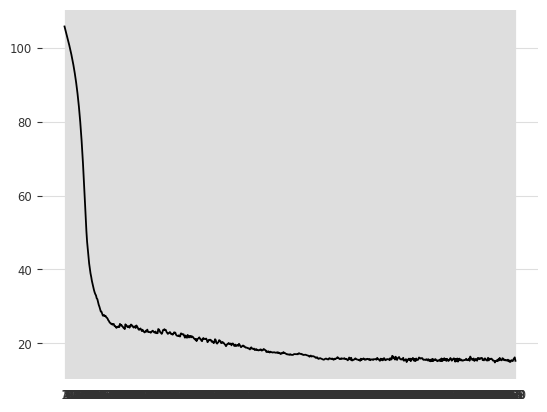

[105.78732, 105.06729, 104.34842, 103.62665, 102.900604, 102.170616, 101.42974, 100.66996, 99.8855, 99.07032, 98.21096, 97.30455, 96.35063, 95.346306, 94.27137, 93.12411, 91.90787, 90.60128, 89.180016, 87.634895, 85.95097, 84.12319, 82.12149, 79.908775, 77.469284, 74.7836, 71.85174, 68.64735, 65.1942, 61.50925, 57.735954, 53.893723, 50.337257, 47.50019, 45.388878, 43.57404, 41.61189, 40.25505, 38.94347, 38.021214, 36.913174, 36.095505, 35.232265, 34.475243, 33.820602, 33.323776, 32.98142, 32.211044, 31.974161, 31.213318, 30.437857, 29.92838, 29.23226, 28.633493, 28.587809, 28.057533, 27.518534, 27.481297, 27.665468, 27.365744, 27.442696, 27.049847, 26.943085, 26.661842, 26.253374, 26.027859, 25.629013, 25.520792, 25.284088, 25.314043, 25.05041, 25.248314, 25.242983, 24.711544, 24.701555, 24.387466, 24.18885, 24.523918, 24.388481, 24.59246, 24.41012, 25.280285, 24.853104, 25.02625, 24.694592, 24.552652, 24.245, 24.153065, 23.864614, 25.1585, 24.845894, 24.817715, 24.42293, 24.39776, 24.

In [164]:
plot_mapes(mapes) # air_milk, 660,1

Try in-memory multi-series

In [165]:
model_fit_files = reset_BlockRNNModels(660, "combined")
air_train = load_data_file("air_train.csv", train_data_path)
milk_train = load_data_file("milk_train.csv", train_data_path)
model_fit_files.fit(series=[air_train, milk_train], val_series=air_val)
pred = model_fit_files.predict(n=36, series=air_hist)
mape(air_val, pred)

Training: 0it [00:00, ?it/s]

16.739399

In [166]:
model_fit_files = reset_BlockRNNModels(660, "combined")
air_train = load_data_file("air_train.csv", train_data_path)
milk_train = load_data_file("milk_train.csv", train_data_path)
model_fit_files.fit(series=[milk_train, air_train], val_series=air_val)
pred = model_fit_files.predict(n=36, series=air_hist)
mape(air_val, pred)

Training: 0it [00:00, ?it/s]

17.128101

From the val_loss curve in TensorBoard, it looks like 100 epochs is enough

In [167]:
model_fit_files = reset_BlockRNNModels(100, "combined")
air_train = load_data_file("air_train.csv", train_data_path)
milk_train = load_data_file("milk_train.csv", train_data_path)
model_fit_files.fit(series=[milk_train, air_train], val_series=air_val)
pred = model_fit_files.predict(n=36, series=air_hist)
mape(air_val, pred)

Training: 0it [00:00, ?it/s]

16.442535

From the plots above it looks like the minimum was obtained by 60% of 660 outer epochs, or approx. 400.

Use 400,1

In [ ]:
# model_fit_files = reset_NBEATSModel()
model_fit_files = reset_BlockRNNModels(1, "epochs_10_66")

mapes = []
milk_air = ["milk_train.csv", "air_train.csv"]
air_milk = ["air_train.csv", "milk_train.csv"]

file_dataset = FileDataset(milk_air, train_data_path)

file_dataloader = FileDataLoader(file_dataset, shuffle=False)
outer_epochs = 400
for outer_epoch in range(outer_epochs):
    print(f"outer_epoch: {outer_epoch+1}")
    for train_series in file_dataloader:
        model_fit_files.fit(series=train_series, val_series=air_val)
        # Potentially delete train_series and call the garbage collector here to free up memory

    pred = model_fit_files.predict(n=36, series=air_hist)
    mapes.append(mape(air_val, pred))

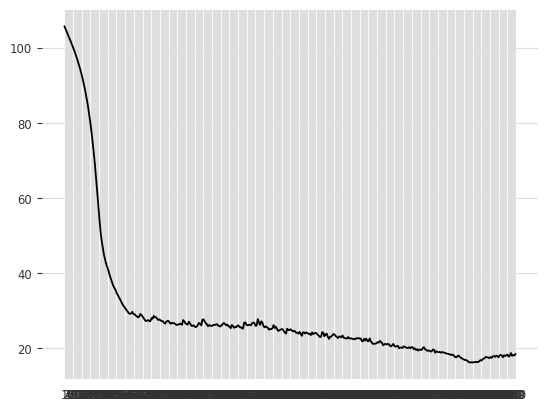

[105.78317, 105.061516, 104.34169, 103.61631, 102.88833, 102.157295, 101.41235, 100.65352, 99.864365, 99.0466, 98.18675, 97.28319, 96.32709, 95.31994, 94.24548, 93.108185, 91.88855, 90.56662, 89.1387, 87.589874, 85.89868, 84.06967, 82.05349, 79.83903, 77.40987, 74.72685, 71.79337, 68.627, 65.1467, 61.485153, 57.764023, 54.0429, 50.72496, 48.439095, 46.543114, 44.803616, 43.48381, 42.37083, 41.45407, 40.584957, 39.426155, 38.542023, 37.655075, 36.770218, 36.143078, 35.65627, 34.837547, 34.230972, 33.690475, 33.1834, 32.527893, 31.930227, 31.38562, 31.031237, 30.555338, 30.146994, 29.766123, 29.313063, 29.18331, 29.315744, 29.72216, 29.145847, 29.074118, 28.69909, 28.554247, 28.240118, 28.415567, 29.165998, 28.87499, 28.541435, 28.086967, 27.559547, 27.299032, 27.365799, 27.535643, 27.240465, 27.251753, 28.066807, 27.895668, 28.649858, 28.267525, 28.268064, 27.908745, 27.535006, 27.707956, 27.439402, 27.229303, 27.233957, 26.797968, 26.574406, 27.093351, 27.287584, 27.310774, 26.842804, 

In [170]:
plot_mapes(mapes) # milk_air, 400,1

Is 40,10 any faster or better? about 4 mins, faster, 50% less time, but not better.  18.46 vs 19.57.  Both worse than Multi in-memory of 16.44

In [ ]:
# model_fit_files = reset_NBEATSModel()
model_fit_files = reset_BlockRNNModels(10, "epochs_10_66")

mapes = []
milk_air = ["milk_train.csv", "air_train.csv"]
air_milk = ["air_train.csv", "milk_train.csv"]

file_dataset = FileDataset(milk_air, train_data_path)

file_dataloader = FileDataLoader(file_dataset, shuffle=False)
outer_epochs = 40
for outer_epoch in range(outer_epochs):
    print(f"outer_epoch: {outer_epoch+1}")
    for train_series in file_dataloader:
        model_fit_files.fit(series=train_series, val_series=air_val)
        # Potentially delete train_series and call the garbage collector here to free up memory

    pred = model_fit_files.predict(n=36, series=air_hist)
    mapes.append(mape(air_val, pred))

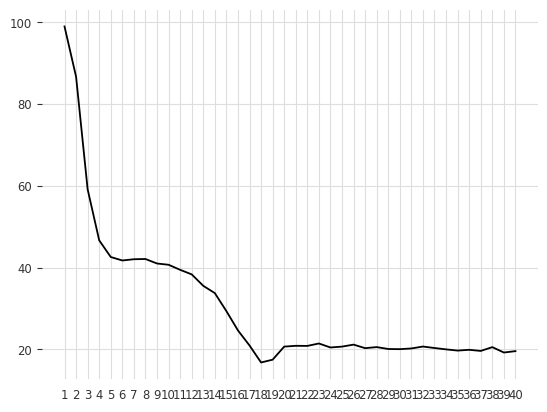

[98.99466, 86.69933, 59.153984, 46.675484, 42.596973, 41.752598, 42.055435, 42.11336, 41.0123, 40.702644, 39.46594, 38.351704, 35.55073, 33.77152, 29.369188, 24.64405, 20.961227, 16.799557, 17.48276, 20.68164, 20.876886, 20.850283, 21.446243, 20.46989, 20.679413, 21.167732, 20.300388, 20.563427, 20.098442, 20.058588, 20.229485, 20.69981, 20.338665, 20.00361, 19.710835, 19.901445, 19.623772, 20.554287, 19.236368, 19.573856]


In [172]:
plot_mapes(mapes) # milk_air, 40,10